In [ ]:
import pandas as pd
import os
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import openpyxl

In [ ]:
# import libraries
os.chdir('/Users/ryan-saloma/Python Projects/string manipulation')

# load data
df = pd.read_csv('movies.csv')

# inspect data
df.head()

Here are some ideas for processing steps:
- Remove alphabetic and parantheses from YEAR column (str.strip, Series.replace)
- Split YEAR column to create start_year and end_year for TV shows (str.split)
- Impute missing values with default missing value indicator in pandas (pd.NA)
- Split STARS column into new director, actors columns
- Split genres into separate columns (Q: how to determine what are the unique values?)
- Change default value for 'ONE-LINE' to None (currently 'Add a Plot')
- For shows that are still on (YEAR = 2020-), fill end_year with appropriate value (present?)

In [ ]:
# Clean data

# Clean YEAR column

# remove alpha characters and parantheses from year column
# NOTE: strip is a string method but replace is a pandas method
df['YEAR'] = df['YEAR'].str.strip().replace(r'[A-Za-z\(\)]', '', regex=True)

# split year range into start and end year columns
df[['start_year','end_year']] = df['YEAR'].str.split('–',expand=True)

# fill missing start year with pd.NA
df['start_year'] = df['start_year'].replace('', pd.NA)

# fill missing end year with pd.NA
df['end_year'] = df['end_year'].replace('', pd.NA).replace(' ', pd.NA)

# Clean STARS column

# Function to extract director
def extract_director(text):
    if("Director:" in text): 
        director = text.split("Director:")[1].split("|")[0].strip()
        return director.strip()
    else:
        return None

# Function to extract actors
def extract_actors(text):
    if("Stars:" in text): 
        actors_part = text.split("Stars:")[1]
        actors = ", ".join([actor.strip() for actor in actors_part.split(",\n")])
        return actors
    else:
        return None

# Apply the functions to create new columns
df['director'] = df['STARS'].apply(extract_director)
df['actors'] = df['STARS'].apply(extract_actors)

# Drop the original STARS column if no longer needed
df = df.drop(columns=['STARS'])

# Clean GENRE column

# remove leading and trailing whitespaces and convert to lowercase
# remove spaces
df['GENRE'] = df['GENRE'].str.strip().str.lower()
df['GENRE'] = df['GENRE'].str.replace(' ','') 
list_of_genres_by_title = df['GENRE'].str.split(',')

# sort each list in x and handle missing values
sorted_list_of_genres_by_title = list_of_genres_by_title.apply(lambda x: sorted(x, reverse=True) if isinstance(x, list) else x)
new_genre_column = sorted_list_of_genres_by_title.str.join(',')
dummies = new_genre_column.str.get_dummies(sep=',').add_prefix('genre_')

# drop temporary data
del list_of_genres_by_title
del sorted_list_of_genres_by_title
del new_genre_column

# # Concatenate the dummies with the original dataframe
df = pd.concat([df, dummies], axis=1)

# Rename columns
df = df.rename(columns={'MOVIES':'title', 'GENRE': 'genre', 'YEAR':'year_range', \
                        'RunTime':'runtime', 'RATING':'rating', 'VOTES':'votes', 'ONE-LINE':'one-line', \
                        'Gross':'gross', 'actors':'actors'})

# convert votes column
df['votes'] = pd.to_numeric(df['votes'].str.replace(',', ''))

# Save the cleaned data
df.to_csv('cleaned_movies.csv', index=False)


In [ ]:
# Perform sentiment analysis on one-line
# TODO: set up to use GPU
# TODO: tune for purposes of this project
sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
df['sentiment'] = df['one-line'].apply(lambda x: sentiment_analysis(x)[0]['label']) 

# get dummies for sentiment
dummies = pd.get_dummies(df['sentiment'], prefix='sentiment')
df = pd.concat([df, dummies], axis=1)

# save the data
df.to_csv('cleaned_movies_with_sentiment.csv', index=False)

In [ ]:
# Analyze relationships

# Load data
df = pd.read_csv('cleaned_movies_with_sentiment.csv')

# explore relationship between sentiment and rating
df.pivot_table(index='sentiment', values='rating', aggfunc=['count', 'mean', 'std', 'max', 'min'])

# visualize the relationship between sentiment and rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='rating', data=df)
plt.title('Boxplot of Ratings by Sentiment')

# explore relationship between genre and rating
genre_columns = [col for col in df.columns if col.startswith('genre_')]
mean_ratings = df.groupby(genre_columns)['rating'].mean()
print(mean_ratings)

# Visualize the relationship between genre and rating

# Melt the DataFrame to long format for seaborn
df_melted = df.melt(id_vars=['rating'], value_vars=genre_columns, var_name='genre', value_name='is_genre')
df_melted = df_melted[df_melted['is_genre'] == 1].dropna()

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='rating', data=df_melted)
plt.xticks(rotation=90)
plt.title('Boxplot of Ratings by Genre')
plt.show()

# Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='genre', y='rating', data=df_melted)
plt.xticks(rotation=90)
plt.title('Violin Plot of Ratings by Genre')
plt.show()


It appears there is no relationship between the sentiment of the description and rating. It does appear, however, that there are differences in ratings by genre, particularly in the spread of ratings and minimum values. For example, while the median rating of horror movies is not drastically different than movies of other genres, the ratings are clearly quite variable, and the worst-rated horror movies appear lower than the worst-rated movies of other genres. 

Follow-up questions: 
- Is there something that the lowest ranked horror movies (or movies in general) share? Can we quantify the amount of overlap between their one-line descriptions?
- Can we control for the number of reviews? What other variables might we want to control for?
- Can a decision tree or random forest reveal any features important to the classification of movie?

In [ ]:
# Create random forest model to predict rating

# first, create bins for rating
bins = [0, 3, 5, 7, 9, 10]
labels = ['very_low', 'low', 'medium', 'high', 'very_high']
df['rating_bin'] = pd.cut(df['rating'], bins=bins, labels=labels)

# second, drop rows with missing values
df = df.dropna(subset=genre_columns + ['rating_bin'])

# drop rows with very_low rating_bin
df = df[df['rating_bin'] != 'very_low']

# third, create a random forest model
model = RandomForestClassifier()

# do some cleanup
# convert votes column to numeric
cols_to_drop = ['title', 'genre', 'year_range', 'rating', 'one-line', 'gross', 'director', 'actors', 'sentiment']
cols_of_interest =[x for x in df.columns if x not in cols_to_drop]
tmp = df.dropna(subset= cols_of_interest + ['rating_bin'])
X = tmp.drop(columns=cols_to_drop + ['rating_bin'])
y = tmp['rating_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# fourth, identify the most important features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# print the feature ranking with column names
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")

# visualize the feature importances and column names
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(X.columns[indices], importances[indices], align="center")
plt.xticks(rotation=90)

There appear to be some relationships between rating and votes, rating and runtime, and rating and year. Next, let's attempt to understand the nature of this relationship.

In [28]:
# create runtime bins
bins = [0, 60, 90, 120, 150, 180, 210, 240, 270, 300]
labels = ['<60', '60-90', '90-120', '120-150', '150-180', '180-210', '210-240', '240-270', '270-300']
df['runtime_bin'] = pd.cut(df['runtime'], bins=bins, labels=labels)

# create a table with mean, median, std of rating by runtime_bin
rating_by_runtime_table = pd.pivot_table(df, index='runtime_bin', values='rating', aggfunc=['count','mean', 'median', 'std'], observed=False)

# create voting bins
bins = [0, 1000, 10000, 100000, 1000000, 10000000]
labels = ['<1k', '1k-10k', '10k-100k', '100k-1M', '1M-10M']
df['votes_bin'] = pd.cut(df['votes'], bins=bins, labels=labels)

# create a table with mean, median, std of rating by votes_bin
rating_by_votes_table = pd.pivot_table(df, index='votes_bin', values='rating', aggfunc=['count','mean', 'median', 'std'], observed=False)

# output the tables
rating_by_runtime_table.to_excel('rating_by_runtime_table.xlsx')
rating_by_votes_table.to_excel('rating_by_votes_table.xlsx')

Unsurprisingly, it looks like movies that have a lot of ratings tend to be higher rated. 

Text(0.5, 1.0, 'Mean Rating by Start Year')

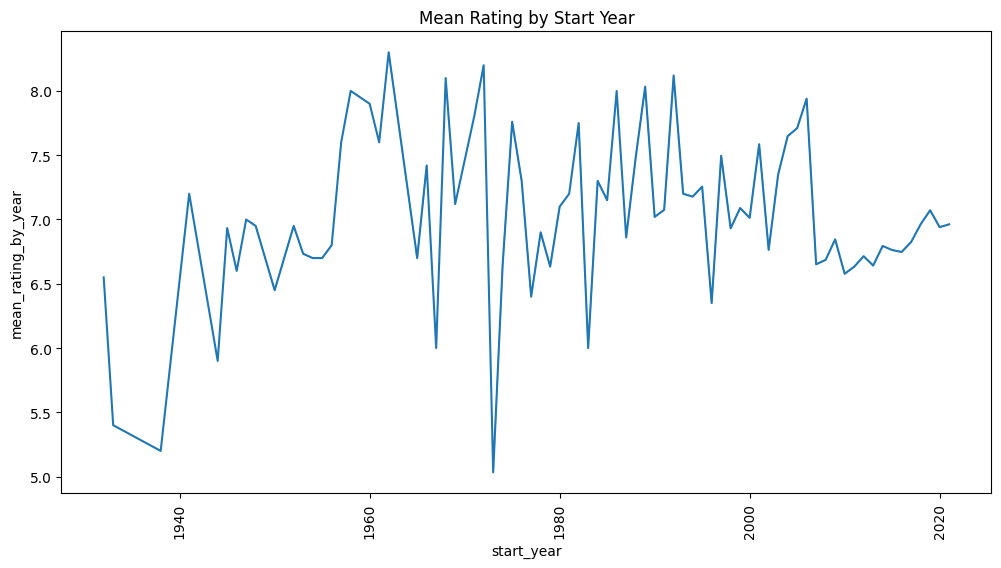

In [32]:
# visualize the relationship between mean rating and start_year
df['start_year'] = pd.to_numeric(df['start_year'])
df['mean_rating_by_year'] = df.groupby('start_year')['rating'].transform('mean')
plt.figure(figsize=(12, 6))
sns.lineplot(x='start_year', y='mean_rating_by_year', data=df)
plt.xticks(rotation=90)
plt.title('Mean Rating by Start Year')